# **Практика 3: Атака Carlini-Wagner (CW) на модели ИИ**

Выполнил(а) студент **2** курса группы: **ББМО-02-23**

ФИО: **Кузина Анастасия Сергеевна**

 # **Цель задания:**

 Изучить одну из наиболее мощных атак на модели ИИ — атаку Carlini-Wagner (CW).


 # **Задача:**
 Научиться использовать CW для создания противоречивых примеров и исследовать влияние этой атаки на обученные модели

#  **Задачи:**
 1. Загрузить ранее обученную модель на датасете **MNIST**.
 2. Изучить теоретические основы атаки **Carlini-Wagner**.
 3. Реализовать атаку **CW** с помощью фреймворка **Foolbox**.
 4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных

# **Шаги выполнения:**

## **Шаг 1: Загрузка обученной модели и данных MNIST**

 Мы начнем с загрузки уже обученной модели и данных MNIST для их использования в атаке.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# Загрузка тестовых данных MNIST:
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в формат one-hot:
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели:
model = tf.keras.models.load_model('/content/mnist_model.h5')
# Проверка точности модели на обычных данных:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9729 - loss: 0.0920
Test accuracy on clean images: 0.975600004196167


##**Шаг 2: Теория Carlini-Wagner Attack**

**Атака Carlini-Wagner (CW)**— это одна из наиболее эффективных атак, созданных для введения
моделей в заблуждение. В отличие от **FGSM**, **CW** использует оптимизационный подход для создания минимальных изменений в изображении, которые приводят к ошибке в классификации модели.

**Цель атаки**     — найти минимальные изменения в изображении, которые переводят его в другую
категорию, оставаясь при этом визуально неотличимыми от оригинала.

Атака **CW** может быть настроена по нескольким параметрам, например, для минимизации **L2**, **L0** или **L∞ норм*, что определяет, как именно модифицируется изображение

##**Шаг 3: Установка Foolbox и запуск CW-атаки**

### Для реализации атаки **Carlini-Wagner** будем использовать фреймворк **Foolbox**, который предоставляет удобные методы для выполнения различных атак на модели ИИ.

In [2]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.0 MB/s eta 0:00:00


### Реализация атаки **Carlini-Wagner**:

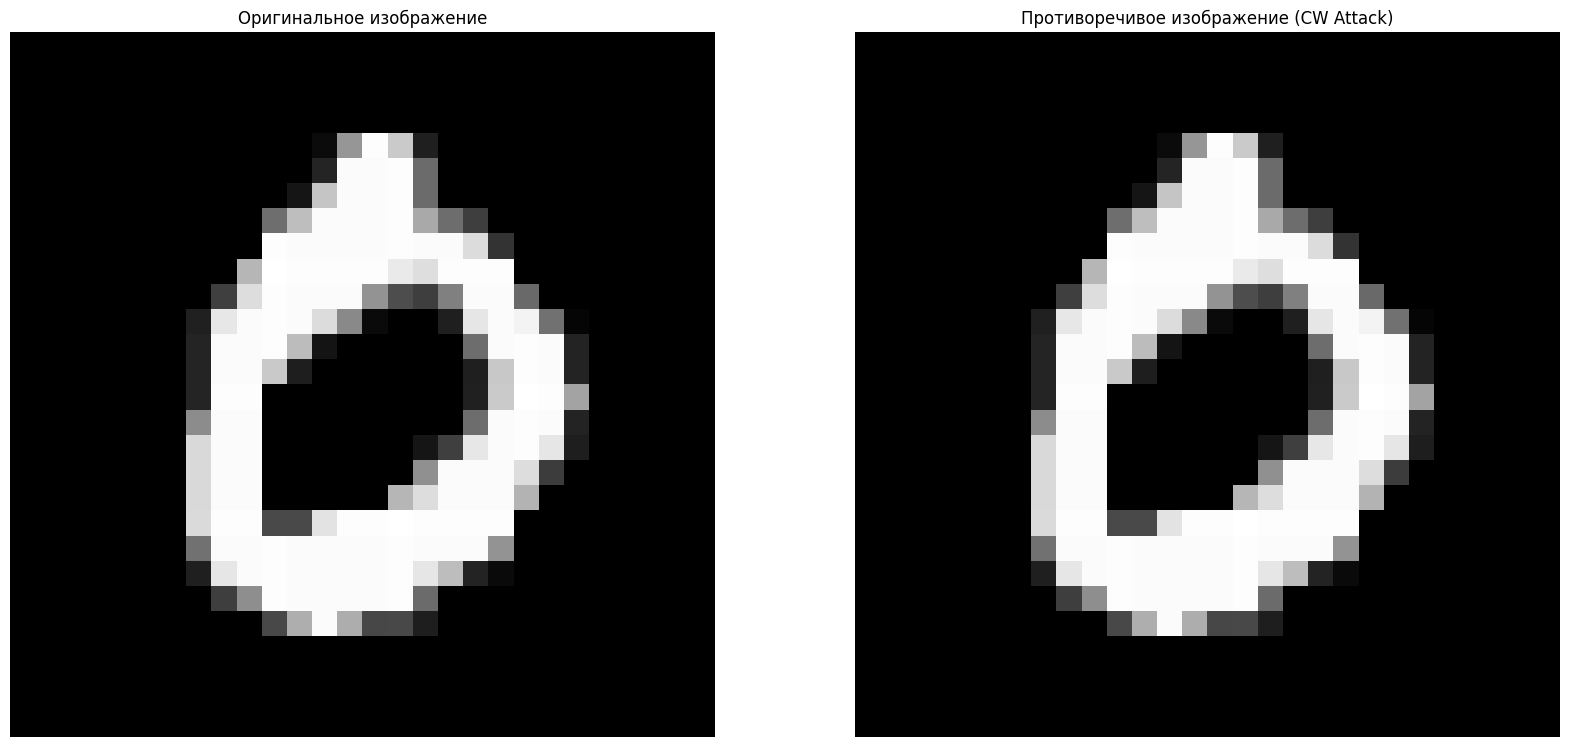

In [11]:
import foolbox as fb
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Инициализация Foolbox модели:
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Выбор изображения для атаки (например, первое изображение из тестового набора):
# Добавление размерности для батча:
image = tf.convert_to_tensor(test_images[3], dtype=tf.float32)[None, ...]
# Получение индекса класса:
label = np.argmax(test_labels[0])
# Преобразование в тензор:
label = tf.convert_to_tensor(label, dtype=tf.int64)

# Создание атаки Carlini-Wagner:
attack = fb.attacks.L2CarliniWagnerAttack(steps=10)
# Выполнение атаки:
adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Вывод результатов:
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (CW Attack)")
plt.imshow(adversarial_image[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

##**Шаг 4: Оценка модели на противоречивых примерах**

### После того, как мы сгенерировали противоречивые примеры, мы можем оценить, насколько атака **Carlini-Wagner** влияет на производительность модели.

In [12]:
# Установка количества обрабатываемых изображений:
adversarial_images = []
num_images = min(100, len(test_images))

# Обработка изображений:
for i in range(num_images):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

# Конвертация списка в массив с правильной формой:
adversarial_images = tf.concat(adversarial_images, axis=0)

# Проверка, что test_labels имеют соответствующее количество меток:
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:num_images])
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0155 - loss: 1.3425 
Accuracy on adversarial examples (CW attack): 0.009999999776482582


##**Шаг 5: Сравнение результатов**

### Наблюдается  резкое падение точности модели на атакованных изображениях, что является ожидаемым результатом из-за особенностей работы атакующих алгоритмов и чувствительности моделей глубокого обучения к небольшим изменениям во входных данных.

### Это подчеркивает важность разработки более устойчивых моделей и методов защиты от атак.